Three-dimensional example:
V:
 [[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.   0.25]]
S:
 [[ 0.          1.73205081  1.        ]
 [-1.73205081  0.          1.        ]
 [-1.         -1.          0.        ]]
c: 0.5333
h: 0.0334
sigma: 0.8109

Nine-dimensional example:
V:
 [[0.8147 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.9058 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.127  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.9134 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.6324 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0975 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.2785 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.5469 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.9575]]
Reversible s: -1.0444
Non-reversible s: -3.2890549959700186
c: 0.4313
h: 0.00070822
sigma: 0.9108


/usr/local/lib/python3.10/dist-packages/cupy/random/_distributions.py:476: FutureWarning: cupy.random.multivariate_normal is experimental. The interface can change in the future.
  _util.experimental('cupy.random.multivariate_normal')
/usr/local/lib/python3.10/dist-packages/cupy/random/_generator.py:337: FutureWarning: cupy.random.RandomState.multivariate_normal is experimental. The interface can change in the future.
  _util.experimental('cupy.random.RandomState.multivariate_normal')



Acceptance ratios:
Three-dimensional example:
Reversible: 0.9501
Non-reversible: 0.93343
Nine-dimensional example:
Reversible: 0.995165
Non-reversible: 0.994638


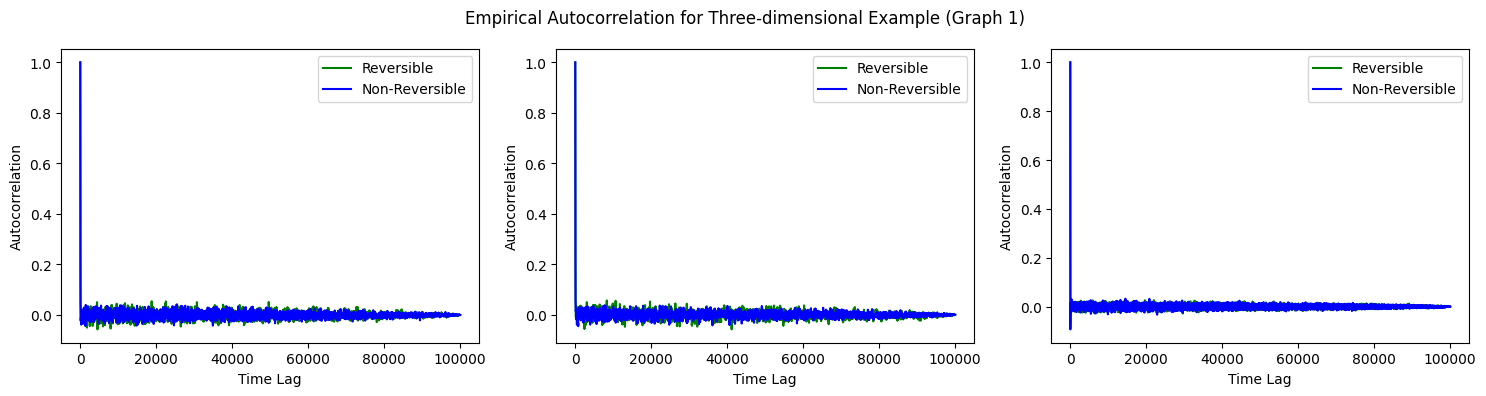

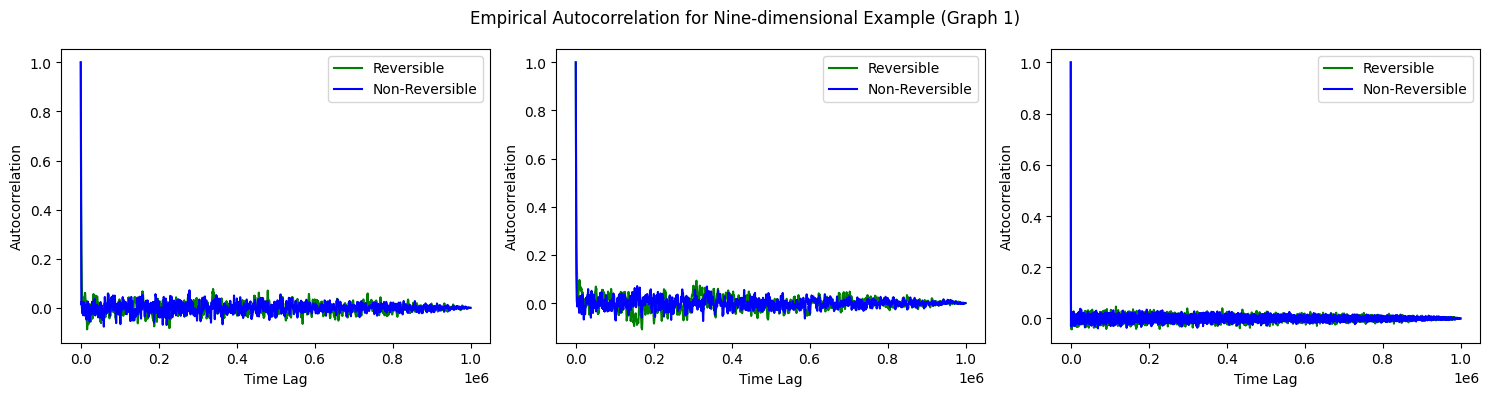

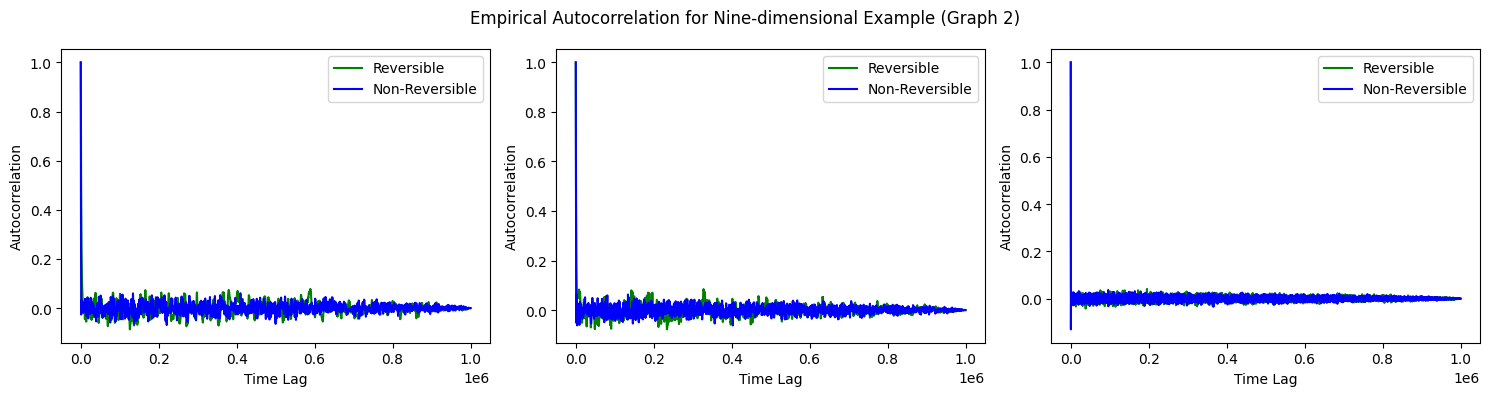

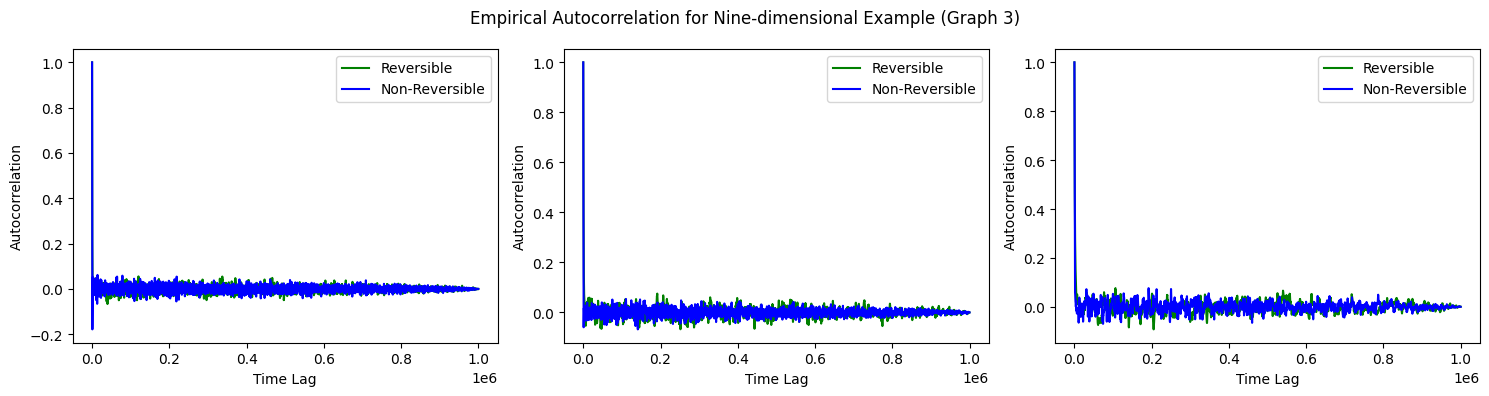

CPU times: user 35min 54s, sys: 11.6 s, total: 36min 6s
Wall time: 36min 27s


In [ ]:
%%time
import cupy as cp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Three-dimensional example
V_3d = cp.diag([1, 1, 1/4])
S_3d = np.array([[0, np.sqrt(3), 1], [-np.sqrt(3), 0, 1], [-1, -1, 0]])
c_3d = 0.5333
h_3d = 0.0334
sigma_3d = 0.8109

# Nine-dimensional example
V_9d = cp.diag([0.8147, 0.9058, 0.1270, 0.9134, 0.6324, 0.0975, 0.2785, 0.5469, 0.9575])
s_reversible = -1.0444
s_non_reversible = -cp.trace(cp.linalg.inv(V_9d)) / V_9d.shape[0]
c_9d = 0.4313
h_9d = 7.0822e-4
sigma_9d = 0.9108

# Function to compute skew-symmetric matrix S
def skew_symmetric_matrix(V):
    n = len(V)
    S = cp.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            S[i, j] = cp.random.uniform(-1, 1)
            S[j, i] = -S[i, j]
    return S

# Function to compute B for non-reversible dynamics
def compute_B_non_reversible(V, S):
    I = cp.eye(len(V))
    return -(I + S) @ cp.linalg.inv(V)

# Function to compute B for reversible dynamics
def compute_B_reversible(V):
    I = cp.eye(len(V))
    return -cp.linalg.inv(V)

# Function to compute R (invariant covariance matrix)
def compute_R(V, B, h, sigma):
    Q = 2 * h * sigma**2 * cp.eye(len(V))
    # Solve discrete Lyapunov equation: R = (I + h * B) @ R @ (I + h * B).T + Q
    R = cp.eye(len(V))
    for _ in range(100):  # Iterative solution
        R = (cp.eye(len(V)) + h * B) @ R @ (cp.eye(len(V)) + h * B).T + Q
    return R

# Function for proposal distribution
def proposal_distribution(X, B, h):
    return cp.random.multivariate_normal((cp.eye(len(X)) + h * B) @ X, 2 * h * cp.eye(len(X)))

# Function to compute acceptance probability
def acceptance_probability(X, Y, R):
    R_X_Y = cp.exp(-0.5 * ((Y - X) @ R @ (Y - X)))
    return min(1, R_X_Y)

# Function to run Metropolis-Hastings algorithm
def run_metropolis_hastings(V, c, h, num_steps, non_reversible=False):
    n = len(V)
    X = cp.zeros(n)
    S = skew_symmetric_matrix(V)
    if non_reversible:
        B = compute_B_non_reversible(V, S)
    else:
        B = compute_B_reversible(V)
    R = compute_R(V, B, h, sigma_3d if not non_reversible else sigma_9d)
    samples = [X.copy()]
    acceptance_count = 0

    for _ in range(num_steps):
        Y = proposal_distribution(X, B, h)
        A = acceptance_probability(X, Y, R)
        u = cp.random.rand()
        if u < A:
            X = Y
            acceptance_count += 1
        samples.append(X.copy())

    acceptance_ratio = acceptance_count / num_steps
    return cp.array(samples), acceptance_ratio

# Printing parameter values
print("Three-dimensional example:")
print("V:\n", V_3d)
print("S:\n", S_3d)
print("c:", c_3d)
print("h:", h_3d)
print("sigma:", sigma_3d)

print("\nNine-dimensional example:")
print("V:\n", V_9d)
print("Reversible s:", s_reversible)
print("Non-reversible s:", s_non_reversible)
print("c:", c_9d)
print("h:", h_9d)
print("sigma:", sigma_9d)

# Running Metropolis-Hastings for the three-dimensional reversible example
num_steps_3d = int(1e5)
samples_3d_reversible, acceptance_ratio_3d_reversible = run_metropolis_hastings(V_3d, c_3d, h_3d, num_steps_3d, non_reversible=False)

# Running Metropolis-Hastings for the three-dimensional non-reversible example
samples_3d_non_reversible, acceptance_ratio_3d_non_reversible = run_metropolis_hastings(V_3d, c_3d, h_3d, num_steps_3d, non_reversible=True)

# Running Metropolis-Hastings for the nine-dimensional example
num_steps_9d = int(1e6)
samples_9d_reversible, acceptance_ratio_9d_reversible = run_metropolis_hastings(V_9d, c_9d, h_9d, num_steps_9d, non_reversible=False)
samples_9d_non_reversible, acceptance_ratio_9d_non_reversible = run_metropolis_hastings(V_9d, c_9d, h_9d, num_steps_9d, non_reversible=True)

# Print acceptance ratios
print("\nAcceptance ratios:")
print("Three-dimensional example:")
print(f"Reversible: {acceptance_ratio_3d_reversible}")
print(f"Non-reversible: {acceptance_ratio_3d_non_reversible}")
print("Nine-dimensional example:")
print(f"Reversible: {acceptance_ratio_9d_reversible}")
print(f"Non-reversible: {acceptance_ratio_9d_non_reversible}")

# Function to compute empirical autocorrelation
def compute_eacf(samples):
    eacf = []
    for i in range(samples.shape[1]):
        eacf.append(sm.tsa.acf(samples.get()[:, i], nlags=len(samples) - 1))
    return cp.array(eacf)

def plot_acf(acf_reversible, acf_non_reversible, title):
    p, n = acf_reversible.shape
    num_graphs = 1  # Set the number of graphs
    if p > 3:
        num_graphs = (p + 2) // 3  # Divide dimensions into groups of 3 for each graph

    for graph_num in range(num_graphs):
        plt.figure(figsize=(15, 4))
        for i in range(3):
            dim_index = graph_num * 3 + i
            if dim_index >= p:
                break
            plt.subplot(1, 3, i+1)
            plt.plot(range(n), acf_reversible.get()[dim_index], label='Reversible', color='green')
            plt.plot(range(n), acf_non_reversible.get()[dim_index], label='Non-Reversible', color='blue')
            plt.xlabel('Time Lag')
            plt.ylabel('Autocorrelation')
            plt.legend()
        plt.suptitle(f"{title} (Graph {graph_num+1})")
        plt.tight_layout()
        plt.show()

# Compute empirical autocorrelation for both three-dimensional examples
eacf_3d_reversible = compute_eacf(samples_3d_reversible)
eacf_3d_non_reversible = compute_eacf(samples_3d_non_reversible)

# Compute empirical autocorrelation for nine-dimensional example
eacf_9d_reversible = compute_eacf(samples_9d_reversible)
eacf_9d_non_reversible = compute_eacf(samples_9d_non_reversible)

# Plot empirical autocorrelation for three-dimensional examples
plot_acf(eacf_3d_reversible, eacf_3d_non_reversible, "Empirical Autocorrelation for Three-dimensional Example")

# Plot empirical autocorrelation for nine-dimensional example
plot_acf(eacf_9d_reversible, eacf_9d_non_reversible, "Empirical Autocorrelation for Nine-dimensional Example")

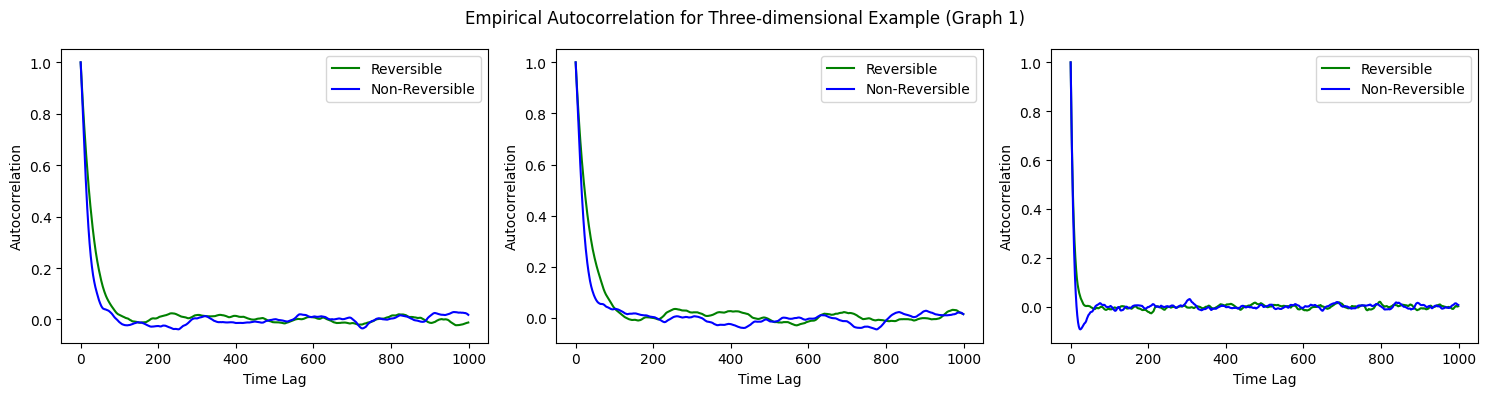

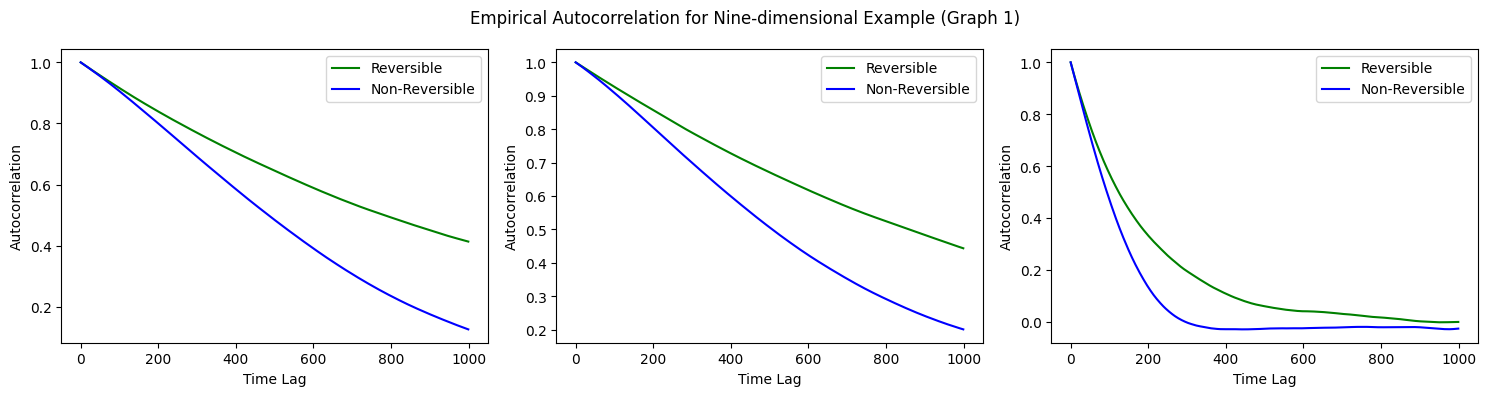

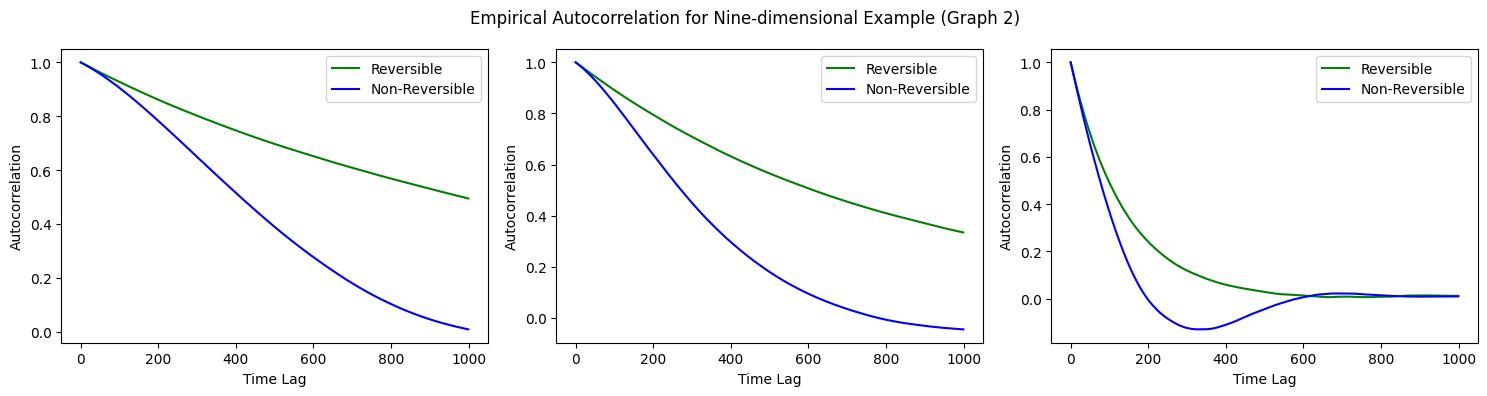

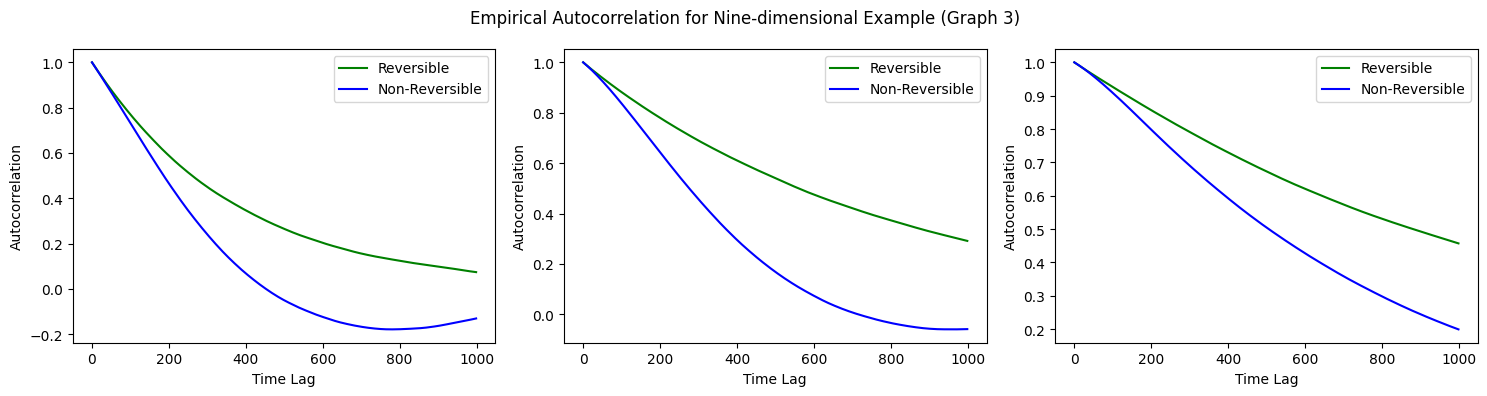

In [ ]:
# Plot empirical autocorrelation for three-dimensional examples
plot_acf(eacf_3d_reversible[:,:1000], eacf_3d_non_reversible[:,:1000], "Empirical Autocorrelation for Three-dimensional Example")

# Plot empirical autocorrelation for nine-dimensional example
plot_acf(eacf_9d_reversible[:,:1000], eacf_9d_non_reversible[:,:1000], "Empirical Autocorrelation for Nine-dimensional Example")

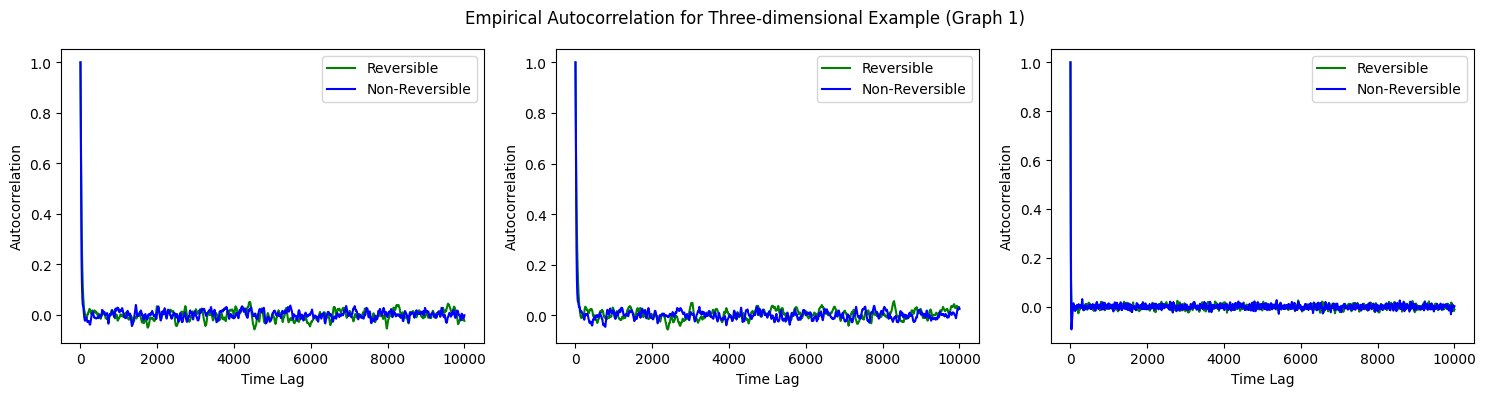

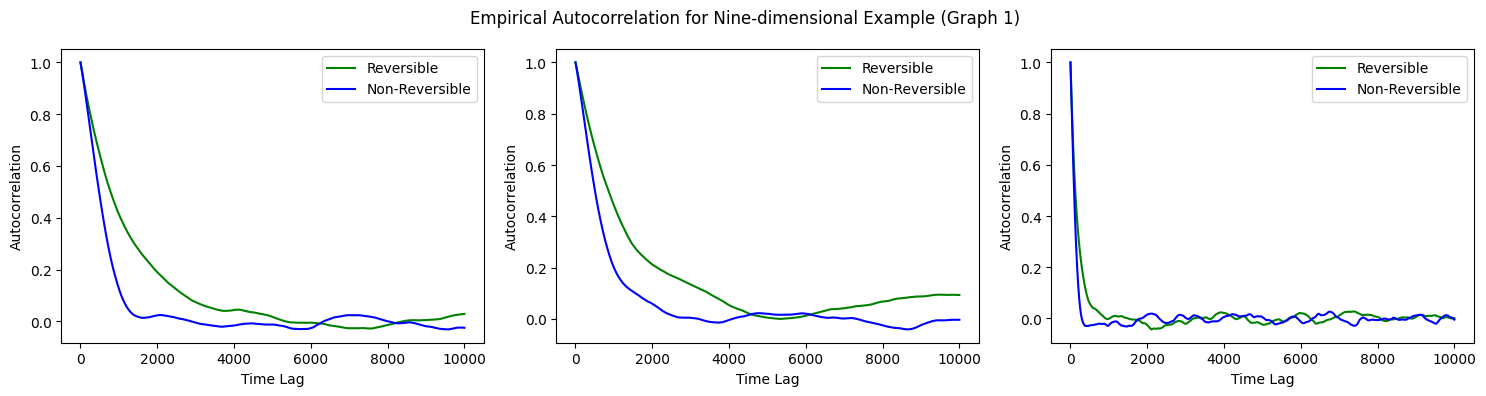

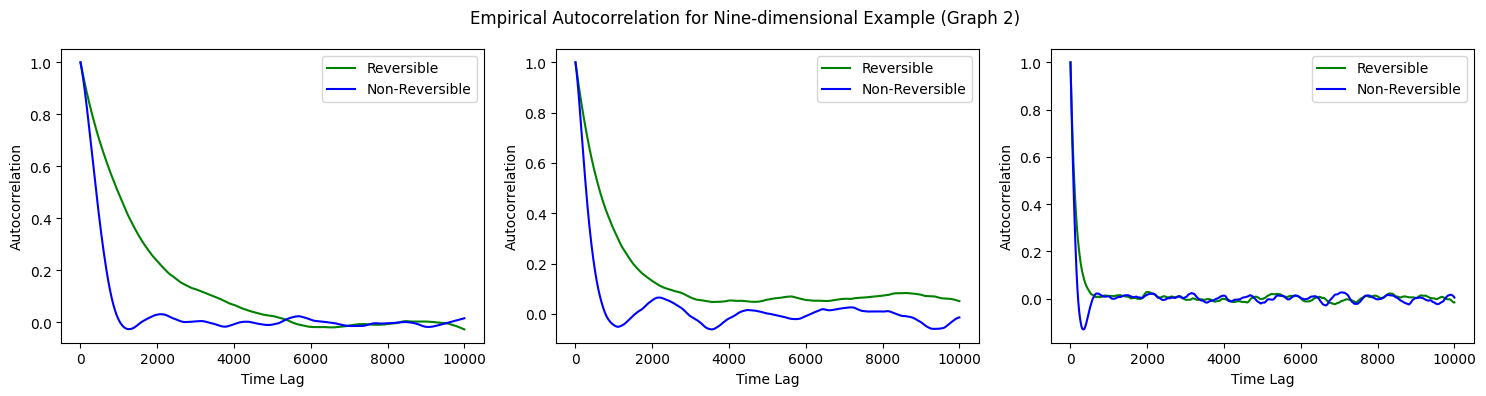

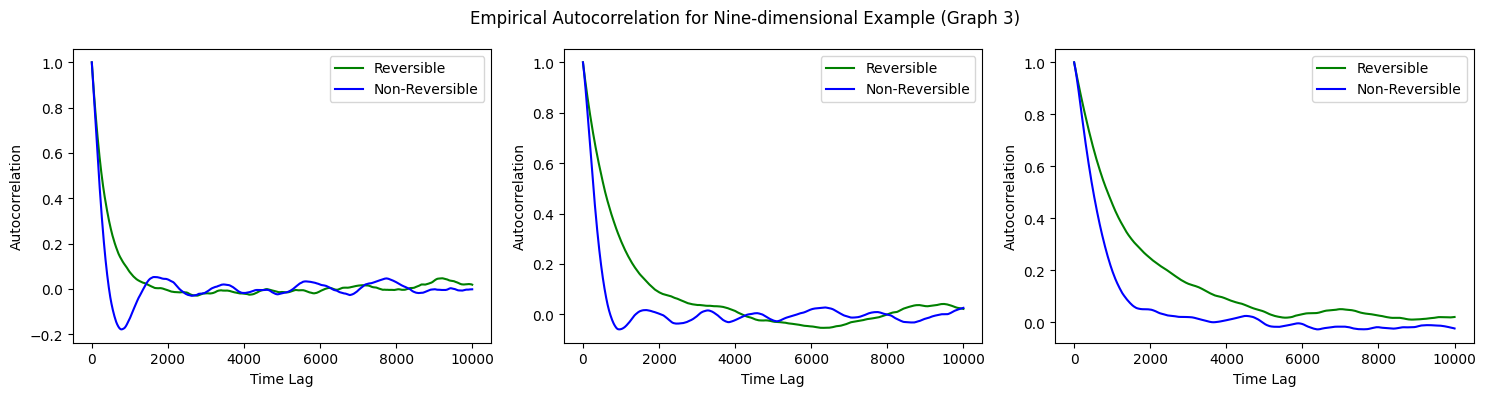

In [ ]:
# Plot empirical autocorrelation for three-dimensional examples
plot_acf(eacf_3d_reversible[:,:10000], eacf_3d_non_reversible[:,:10000], "Empirical Autocorrelation for Three-dimensional Example")

# Plot empirical autocorrelation for nine-dimensional example
plot_acf(eacf_9d_reversible[:,:10000], eacf_9d_non_reversible[:,:10000], "Empirical Autocorrelation for Nine-dimensional Example")

In [ ]:
np.sum(np.abs(eacf_3d_reversible.get()))

2470.716866069678

In [ ]:
np.sum(np.abs(eacf_3d_non_reversible.get()))

2072.974196451388

In [ ]:
np.sum(np.abs(eacf_9d_reversible.get()))

134847.4574846967

In [ ]:
np.sum(np.abs(eacf_9d_non_reversible.get()))

101032.98392732532

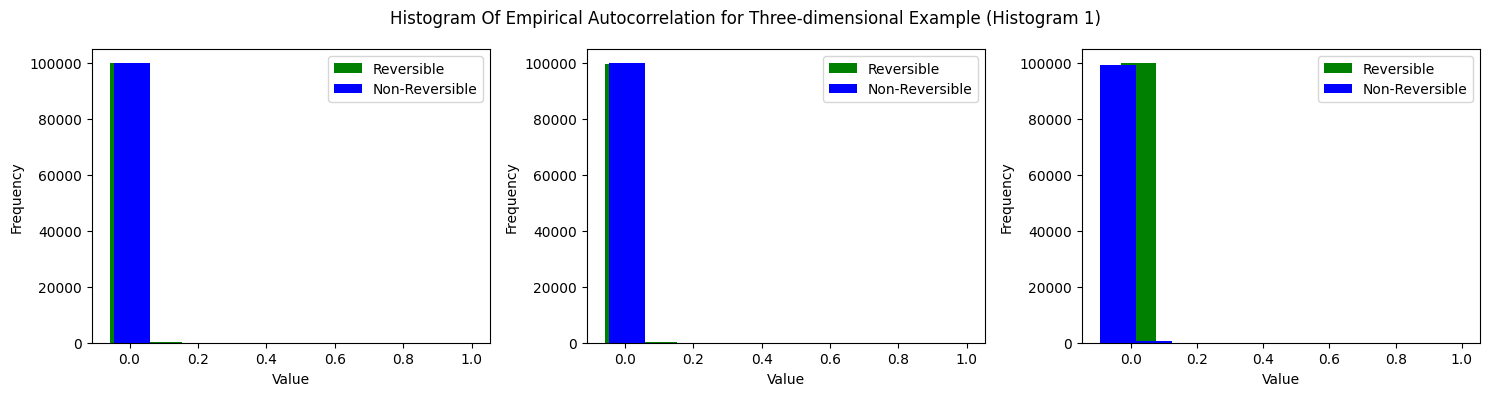

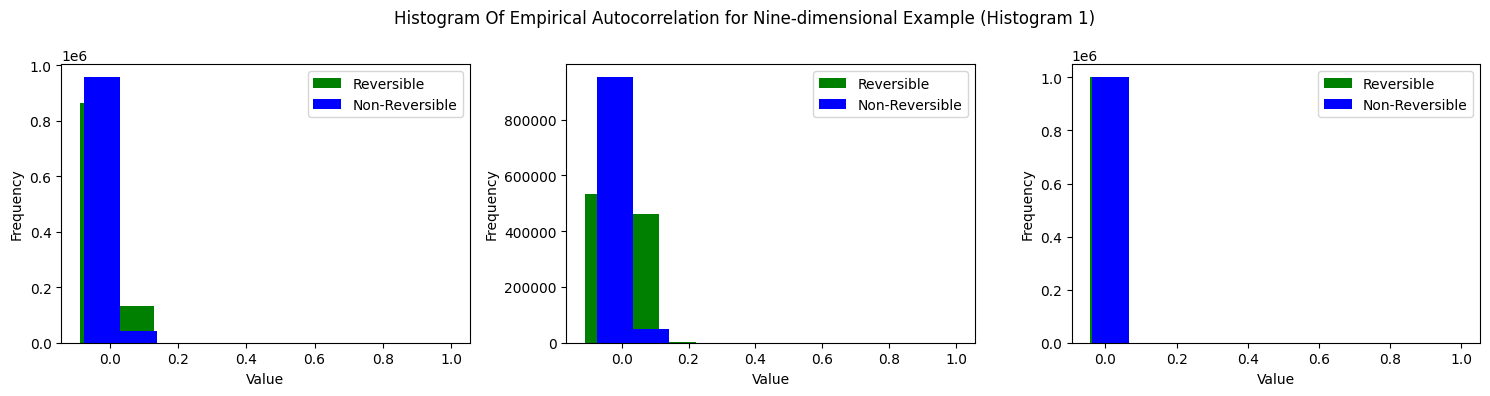

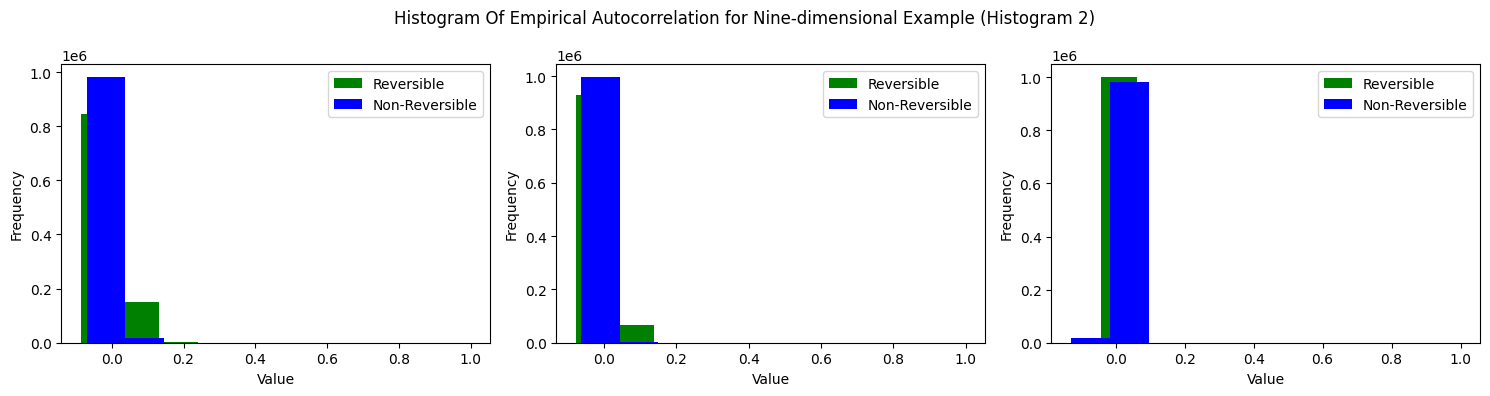

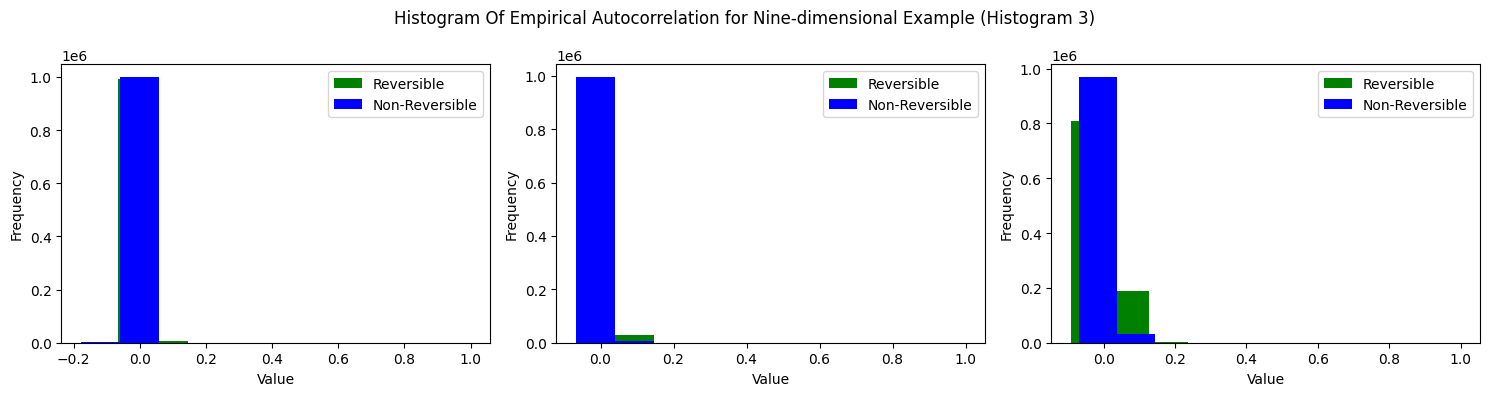

In [ ]:
def plot_hist_acf(samples_reversible, samples_non_reversible, title):
    p, n = samples_reversible.shape
    num_graphs = 1  # Set the number of graphs
    if p > 3:
        num_graphs = (p + 2) // 3  # Divide dimensions into groups of 3 for each graph

    for graph_num in range(num_graphs):
        plt.figure(figsize=(15, 4))
        for i in range(3):
            dim_index = graph_num * 3 + i
            if dim_index >= p:
                break
            plt.subplot(1, 3, i+1)
            plt.hist(samples_reversible.get()[dim_index], label='Reversible', color='green')
            plt.hist(samples_non_reversible.get()[dim_index], label='Non-Reversible', color='blue')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.legend()
        plt.suptitle(f"{title} (Histogram {graph_num+1})")
        plt.tight_layout()
        plt.show()

plot_hist_acf(eacf_3d_reversible, eacf_3d_non_reversible, "Histogram Of Empirical Autocorrelation for Three-dimensional Example")
plot_hist_acf(eacf_9d_reversible, eacf_9d_non_reversible, "Histogram Of Empirical Autocorrelation for Nine-dimensional Example")

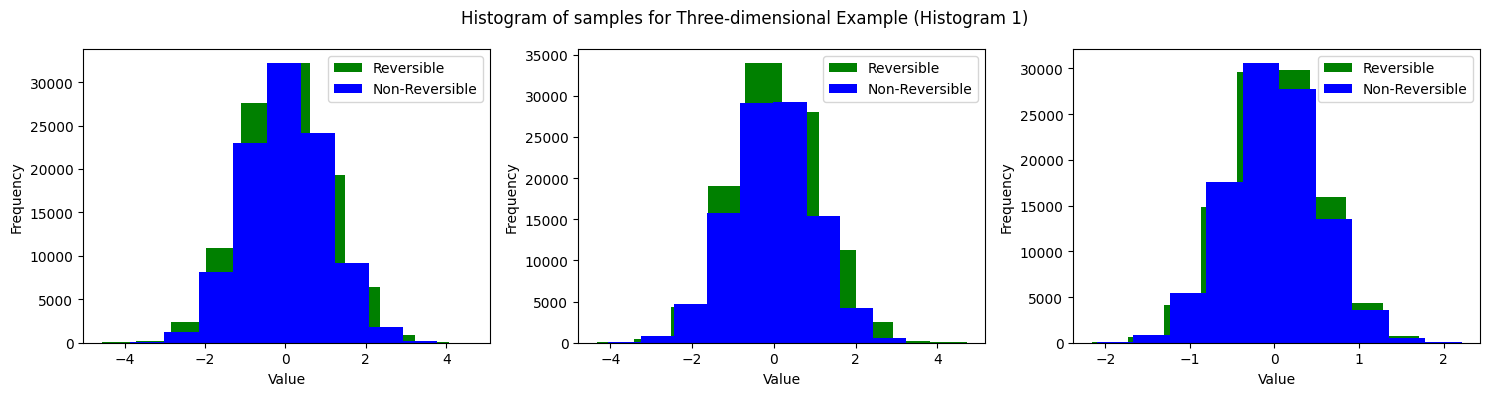

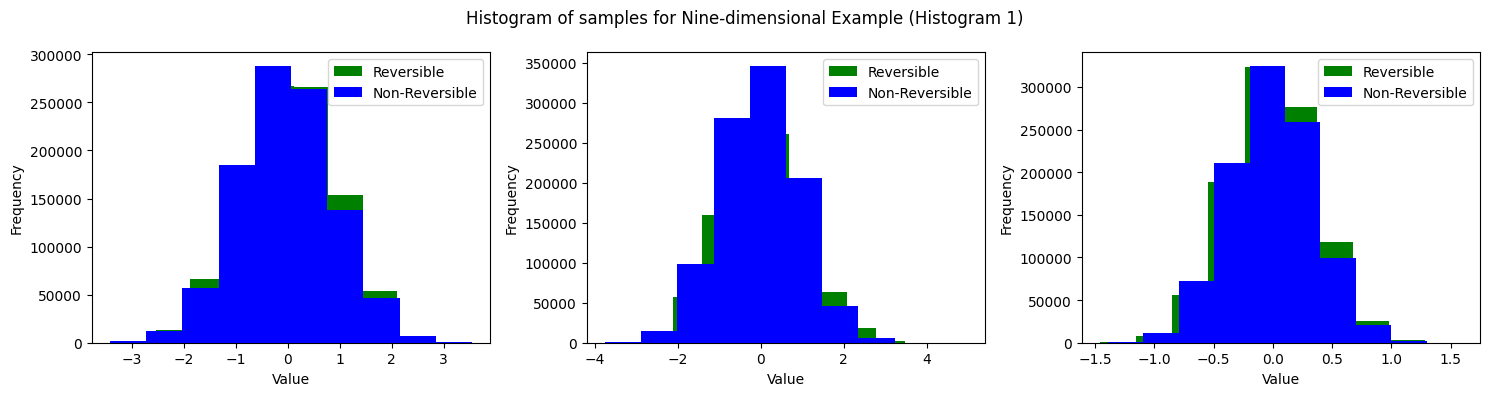

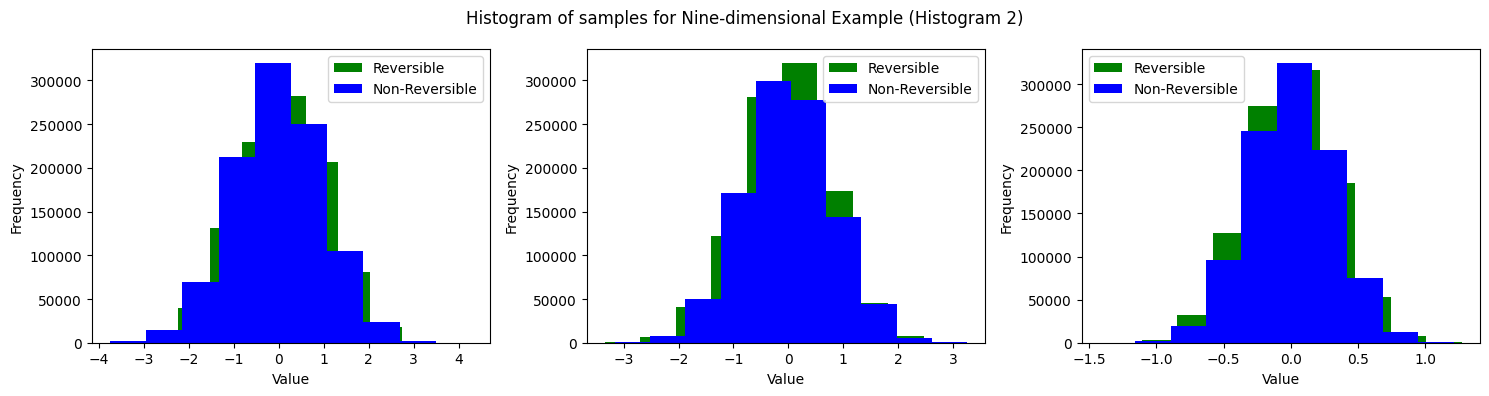

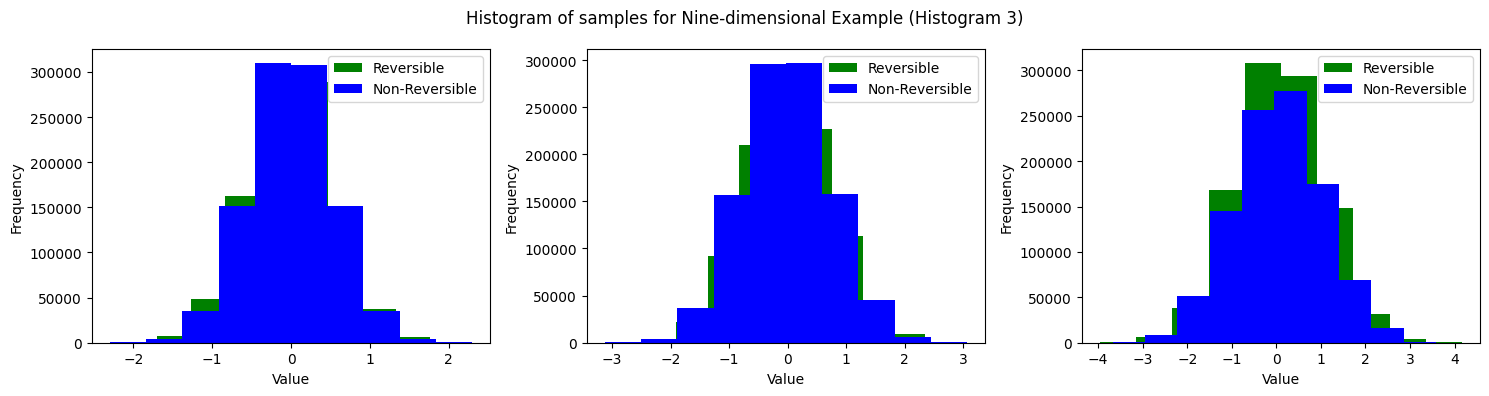

In [ ]:
def plot_hist_samples(samples_reversible, samples_non_reversible, title):
    n, p = samples_reversible.shape
    num_graphs = 1  # Set the number of graphs
    if p > 3:
        num_graphs = (p + 2) // 3  # Divide dimensions into groups of 3 for each graph

    for graph_num in range(num_graphs):
        plt.figure(figsize=(15, 4))
        for i in range(3):
            dim_index = graph_num * 3 + i
            if dim_index >= p:
                break
            plt.subplot(1, 3, i+1)
            plt.hist(samples_reversible.get()[:,dim_index], label='Reversible', color='green')
            plt.hist(samples_non_reversible.get()[:,dim_index], label='Non-Reversible', color='blue')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.legend()
        plt.suptitle(f"{title} (Histogram {graph_num+1})")
        plt.tight_layout()
        plt.show()

plot_hist_samples(samples_3d_reversible, samples_3d_non_reversible, "Histogram of samples for Three-dimensional Example")
plot_hist_samples(samples_9d_reversible, samples_9d_non_reversible, "Histogram of samples for Nine-dimensional Example")